In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from src.nonlinear_approx_vf import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Part One

In [2]:
# read dataset
delta_t = 0.1
x0_df = pd.read_csv('datasets/nonlinear_vectorfield_data_x0.txt',delim_whitespace=True, names=["x0", "y0"])
x0_data = np.array(x0_df,dtype=float)
x1_df = pd.read_csv('datasets/nonlinear_vectorfield_data_x1.txt',delim_whitespace=True, names=["x1", "y2"])
x1_data = np.array(x1_df,dtype=float)
v_data = (x1_data - x0_data) / delta_t

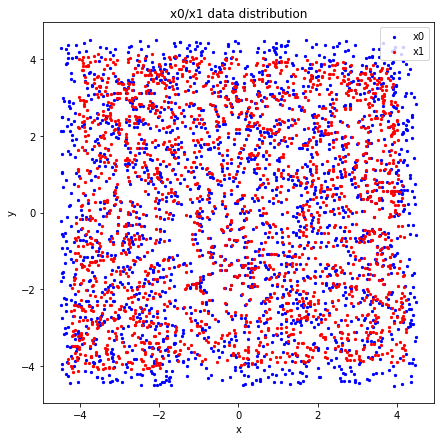

In [3]:
# plot x0 and x1
fig1 = plt.figure(figsize=(7,7))
ax1 = fig1.add_subplot()
ax1.scatter(x0_data[:,0], x0_data[:, 1], c='b', s=5, label='x0')
ax1.scatter(x1_data[:,0], x1_data[:, 1], c='r', s=5, label="x1")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("x0/x1 data distribution")
ax1.legend()

Text(0.5, 1.0, 'flow using the finite-difference formula')

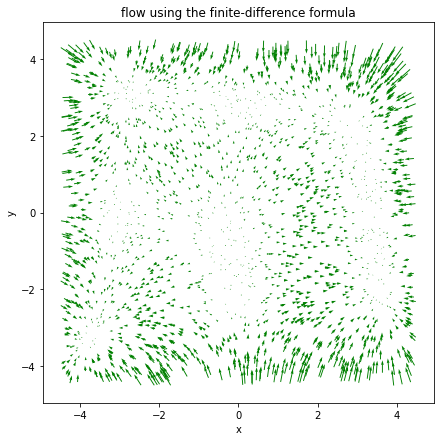

In [4]:
# plot flow using the finite-difference formula
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot()
ax.quiver(x0_data[:,0], x0_data[:, 1], v_data[:,0], v_data[:, 1], color='g')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("flow using the finite-difference formula")

In [5]:
# get approximated A
nr = x0_data.shape[0]
A = np.linalg.lstsq(x0_data, v_data, rcond=None)[0].T

In [6]:
A

array([[-0.10016012, -0.00253494],
       [ 0.00867272, -0.43267138]])

In [7]:
# calculate predicted x1
eq = lambda t, x: A @ x
x1_sol = np.zeros((nr, 2))
for i in range(nr):
    x1_sol[i, :] = solve_ivp(eq, t_span=[0, 0.2], t_eval=[0.1], y0=x0_data[i, :]).y.reshape(-1)

In [8]:
# mse loss
np.mean(np.sum((x1_sol - x1_data)**2, axis = -1))

0.037275818443270936

Text(0.5, 1.0, 'predicted flow using linear model')

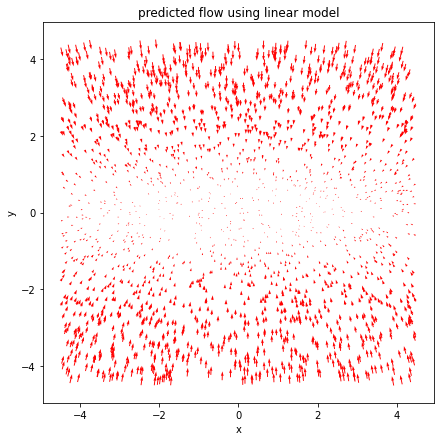

In [9]:
# plot predicted flow using ivp solver
v_sol = (x1_sol - x0_data) / delta_t
fig2 = plt.figure(figsize=(7,7))
ax2 = fig2.add_subplot()
ax2.quiver(x0_data[:,0], x0_data[:, 1], v_sol[:,0], v_sol[:, 1], color='r')
# ax2.quiver(x0_data[:,0], x0_data[:, 1], v_data[:,0], v_data[:, 1], color='g')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("predicted flow using linear model")

## Part Two

In [10]:
nr_xl = 100
id_xl = rand_idx(x0_data, nr_xl)
min_esp = find_best_eps(x0_data, nr_xl, delta_t, x1_data, v_data)
print(min_esp)

5.336842105263157


In [11]:
eps = 5.33
phi = get_phi(x0_data, nr_xl, id_xl, x0_data, eps)
phi.shape

(2000, 100)

In [12]:
C = np.linalg.lstsq(phi, v_data, rcond=None)[0]
C.shape

(100, 2)

In [13]:
x1_sol = np.zeros((nr, 2))
v_sol = phi @ C

Text(0.5, 1.0, 'predicted flow using RBF model')

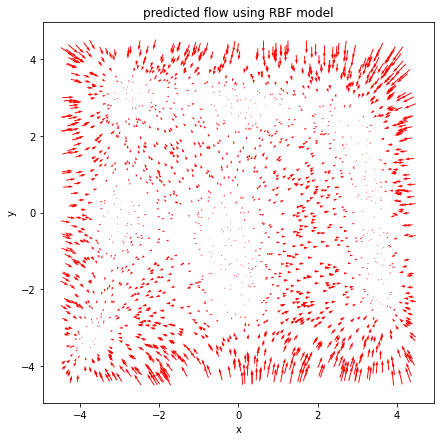

In [14]:
# predicted flow using RBF model
fig3 = plt.figure(figsize=(7,7))
ax3 = fig3.add_subplot()
ax3.quiver(x0_data[:,0], x0_data[:, 1], v_sol[:,0], v_sol[:, 1], color='r')
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_title("predicted flow using RBF model")

In [15]:
# mse loss
#x1_sol = v_sol * delta_t + x0_data

eq = lambda t, x: get_phi(x0_data, nr_xl, id_xl, x.reshape((1, 2)), eps) @ C
x1_sol = np.zeros((nr, 2))
for i in range(nr):
    x1_sol[i, :] = solve_ivp(eq, t_span=[0, 0.2], t_eval=[0.1], y0=x0_data[i, :]).y.reshape(-1)

np.mean(np.sum((x1_sol - x1_data)**2, axis = -1))

0.0008435959358754188

Text(0.5, 1.0, 'phase portrait')

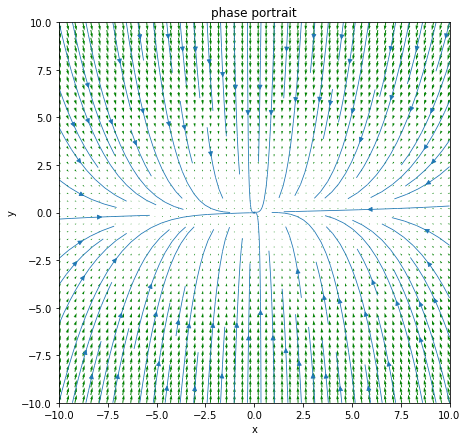

In [16]:
# plot predicted plot, plot stream
x, y = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
u, v = np.zeros_like(x), np.zeros_like(y)


u = A[0][0] * x + A[0][1] * y
v = A[1][0] * x + A[1][1] * y

fig4 = plt.figure(figsize=(7,7))
ax4 = fig4.add_subplot()
ax4.quiver(x, y, u, v, color='g')
ax4.streamplot(x, y, u, v, linewidth=0.8)
ax4.set_xlabel("x")
ax4.set_ylabel("y")
ax4.set_title("phase portrait")

## Part Three

In [23]:
# iteration to get x1 posisiton
steps = 3000
nr_xl = 100

loss = []
x1_sol = np.empty((steps, x1_data.shape[0], x1_data.shape[1]))
x1_sol[0] = x0_data
converged_step = 0
for i in range(1, steps):
    phi = get_phi(x0_data, nr_xl, id_xl, x1_sol[i - 1], eps)
    v_sol = phi @ C
    x1_sol[i] = x1_sol[i - 1] + delta_t * v_sol
    if np.mean(np.sum((x1_sol[i] - x1_sol[i-1])**2, axis = -1)) < 1e-9:
        print("after {0}'s steps, mse loss converged".format(i))
        converged_step = i
        break

after 235's steps, mse loss converged


In [24]:
eq = lambda t, x: get_phi(x0_data, nr_xl, id_xl, x.reshape((1, 2)), eps) @ C
x1_sol = np.zeros((nr, 2))
for i in range(nr):
    x1_sol[i, :] = solve_ivp(eq, t_span=[0, 24], t_eval=[24], y0=x0_data[i, :]).y.reshape(-1)

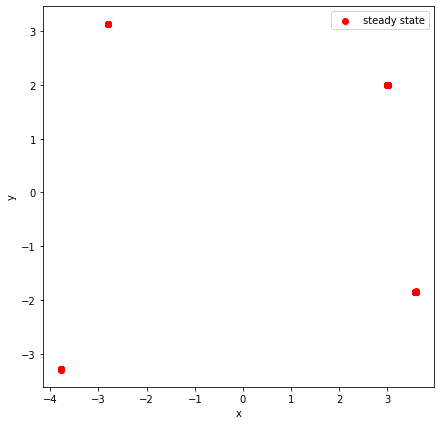

In [25]:
# plot steady state after convergence
fig5 = plt.figure(figsize=(7,7))
ax5 = fig5.add_subplot()
ax5.scatter(x1_sol[:, 0], x1_sol[:, 1], c='r', label='steady state')
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.legend()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

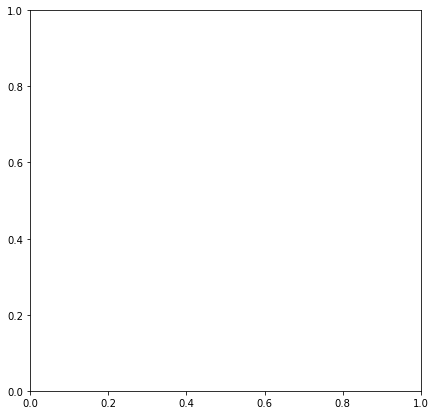

In [20]:
# plot steady state after convergence
fig5 = plt.figure(figsize=(7,7))
ax5 = fig5.add_subplot()
ax5.scatter(x1_sol[converged_step, :, 0], x1_sol[converged_step, :, 1], c='r', label='steady state')
ax5.set_xlabel("x")
ax5.set_ylabel("y")
ax5.legend()

In [ ]:
np.sort(x1_sol[converged_step, :, 0])

In [ ]:
np.sort(x1_sol[converged_step, :, 1])